In [1]:
import numpy as np
import seaborn as sb

from Data_manager.split_functions.split_train_validation_random_holdout import \
        split_train_in_two_percentage_global_sample
from Utils.recsys2022DataReader import *
import matplotlib.pyplot as plt

In [2]:
URM = createURM()

C:\Users\Mike\PycharmProjects\recsys-challenge-2022-Pancini-Vitali\Utils\recsys2022DataReader.py:15: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(urmPath)


In [3]:
ICM = createSmallICM()

In [4]:
profile_length = np.ediff1d(URM.indptr)
profile_length, profile_length.shape

(array([ 66,  21, 103, ...,  23,  53,  23], dtype=int32), (41629,))

In [5]:
block_size = int(len(profile_length)*0.25)
block_size

10407

In [6]:
sorted_users = np.argsort(profile_length)
sorted_users

array([38400, 30257, 25061, ..., 19407,  8693, 12454], dtype=int64)

In [7]:
URM_train, URM_test = split_train_in_two_percentage_global_sample(URM, train_percentage=0.85)

<AxesSubplot:ylabel='Count'>

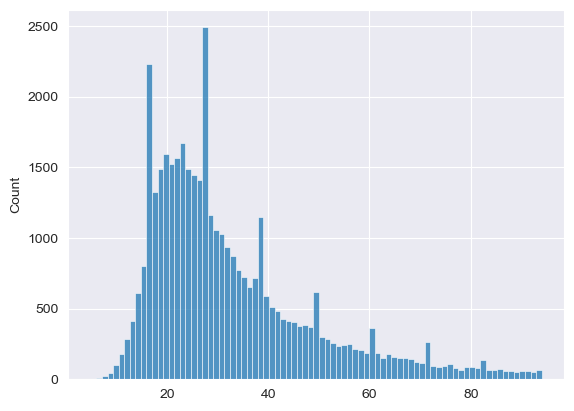

In [8]:
interactions = []
for i in range(41629):
    interactions.append(len(URM[i,:].nonzero()[0]))

#interactions = np.array(inter).sort()
interactions_to_plot = sorted(interactions)[:40000]

sb.histplot(interactions_to_plot)

In [24]:
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.ItemKNNCFRecommenderPLUS import ItemKNNCFRecommender
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.Implicit.ImplicitALSRecommender import ImplicitALSRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "ImplicitALSRecommender": ImplicitALSRecommender,
                                   #"SlimElasticNet": MultiThreadSLIM_SLIMElasticNetRecommender,
                                   }

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train)
    if(label == 'ItemKNNCF'):
        recommender_object.fit(ICM=ICM*53, shrink=15.254006295776568, topK=235, similarity='rp3beta', normalization='tfidf')
    elif(label == 'P3alpha'):
        recommender_object.fit(topK=218, alpha=0.8561168568686058)
    elif(label == 'RP3beta'):
        recommender_object.fit(alpha=0.5126756776495514, beta=0.396119587486951, topK=100)
    elif(label == 'ImplicitALSRecommender'):
        recommender_object.fit(iterations=94, factors=287, alpha=10, regularization=0.01)
    elif(label == 'SlimElasticNet'):
        recommender_object.fit(topK=359, alpha=0.04183472018614359, l1_ratio=0.03260349571135893)
    else:
        recommender_object.fit()

    recommender_object_dict[label] = recommender_object

Done: 100%|██████████| 24507/24507 [00:00<00:00, 30146.26it/s]            


P3alphaRecommender: Similarity column 24507 (100.0%), 2355.01 column/sec. Elapsed time 10.41 sec
RP3betaRecommender: Similarity column 24507 (100.0%), 2803.11 column/sec. Elapsed time 8.74 sec


  0%|          | 0/94 [00:00<?, ?it/s]

In [28]:
cutoff = 10
from Evaluation.Evaluator import EvaluatorHoldout

list_group_interactions = [[0, 20] , [21, 25], [26, 49], [50, max(interactions)]]
for group_id in range(0, 4):
    lower_bound = list_group_interactions[group_id][0]
    higher_bound = list_group_interactions[group_id][1]

    users_in_group = [user_id for user_id in range(len(interactions)) if (lower_bound <= interactions[user_id] <= higher_bound)]
    users_in_group_p_len = profile_length[users_in_group]

    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    print(f"Evaluating group: {group_id}")

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Evaluating group: 0
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 32533 Users
EvaluatorHoldout: Processed 8454 (100.0%) in 6.28 sec. Users per second: 1347
EvaluatorHoldout: Processed 8454 (100.0%) in 5.62 sec. Users per second: 1504
EvaluatorHoldout: Processed 8454 (100.0%) in 5.25 sec. Users per second: 1610
EvaluatorHoldout: Processed 8454 (100.0%) in 5.23 sec. Users per second: 1617
EvaluatorHoldout: Processed 8454 (100.0%) in 6.41 sec. Users per second: 1319
Evaluating group: 1
EvaluatorHoldout: Ignoring 902 ( 2.2%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 33938 Users
EvaluatorHoldout: Processed 7531 (100.0%) in 5.42 sec. Users per second: 1388
EvaluatorHoldout: Processed 7531 (100.0%) in 5.40 sec. Users per second: 1394
EvaluatorHoldout: Processed 7531 (100.0%) in 5.37 sec. Users per second: 1403
EvaluatorHoldout: Processed 7531 (100.0%) in 5.04 sec. Users per second: 1495
EvaluatorH

KeyboardInterrupt: 

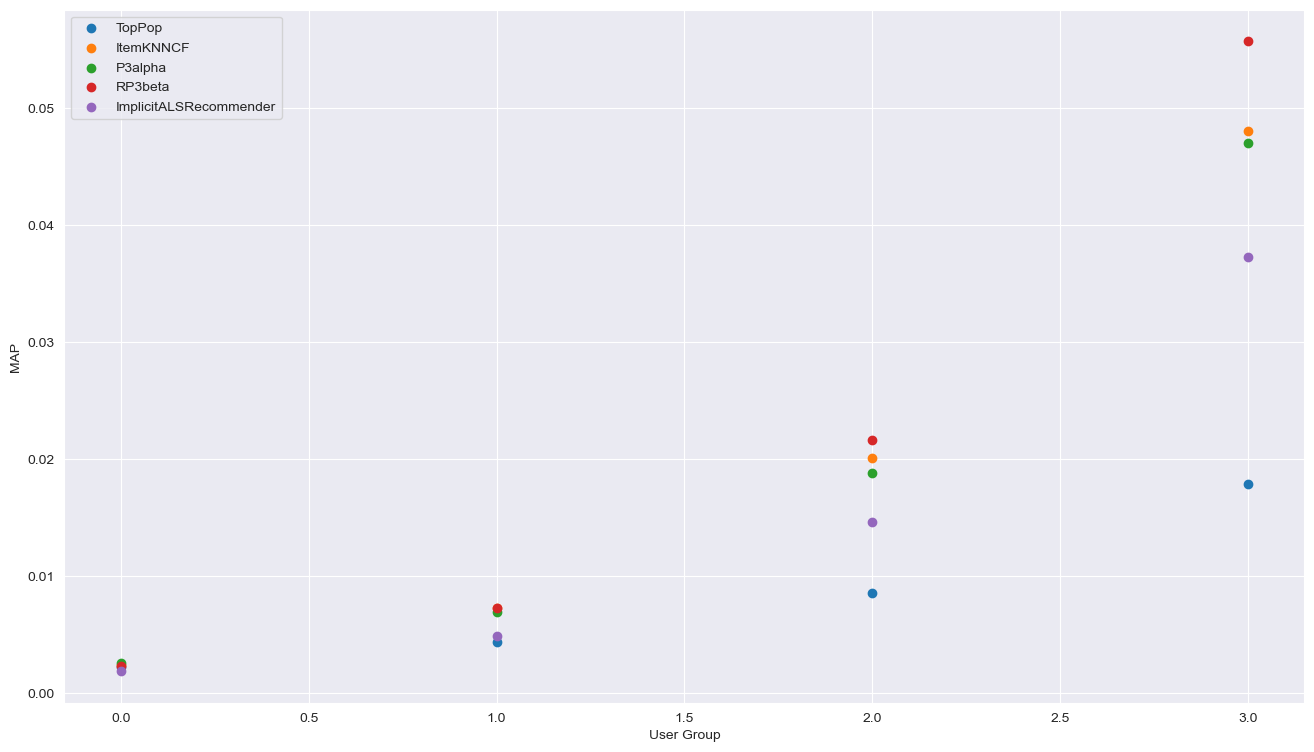

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()